The main aim of this notebook is to demo the low level energy_py API.  All of the functionality exposed here is wrapped into a higher level API that can be accessed by

```bash
$ cd energy_py/experiments

$ python experiment.py example dqn
```

This higher level API wraps more functionality than is exposed int his example - i.e. generating log files and writing data to TensorBoard.  For the scope of this low level example, we will just use data available locally - episode rewards in the `Runner` class and data for the last episode - the `info` dictionary.

This notebook also demonstrates the ability of a DQN agent to learn to optimize simplfied electric battery storage.

This example involves a constant and repetitive electricity price profile, combined with a perfect forecast. The agent has both the ability to memorize this profile and lives in a near Markov environment.  More interesting work randomly samples different price rollouts and uses realistic forecasts.  

A real world application of using reinforcement learning to control a battery would have to deal with both a variable price profile and a non-Markov understanding of what the price profile would do in the future.  It could also involve additional reward signals, such as payments from fast frequency response needed to be balanced against price arbitrage.

In [1]:
from datetime import datetime
import os
import random

import numpy as np
import pandas as pd
import tensorflow as tf

import energy_py

/Users/adam/anaconda3/envs/energy_py/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/adam/anaconda3/envs/energy_py/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#  define a total number of steps for the experiment to run
TOTAL_STEPS = 500000

#  to setup the agent we use a dictionary
#  a dictionary allows us to eaisly save the config to csv if we want
agent_config = {
    'discount': 0.97,                 #  the discount rate
    'tau': 0.001,                     #  parameter that controls the copying of weights from online to target network
    'total_steps': TOTAL_STEPS,   
    'batch_size': 32,                 #  size of the minibatches used for learning
    'layers': (50, 50),               #  structure of the neural network used to approximate Q(s,a)
    'learning_rate': 0.0001,          #  controls the stength of weight updates during learning       
    'epsilon_decay_fraction': 0.3,    #  a fraction as % of total steps where epsilon decayed from 1.0 to 0.1
    'memory_fraction': 0.4,           #  the size of the replay memory as a % of total steps
    'memory_type': 'deque',           #  the replay memory implementation we want
               }

#  keep all of the BatteryEnv variables (episode length, efficiency etc) at their defaults
#  we just need to let our env know where our state.csv and observation.csv are (data_path)
env = energy_py.make_env('battery')

#  set seeds for reproducibility
env.seed(42)

def print_time():
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [3]:
print_time()
#  reset the graph (without this nb needs to be restart each time)
tf.reset_default_graph()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    
    #  Runner is a class that helps us with experiments - tracking rewards, writing environment info to csv and managing TensorBoard
    #  in this notebook we just use it to track rewards for us
    runner = energy_py.Runner(
        sess,  
        {'tb_rl': './tb_rl',
         'ep_rewards': './rewards.csv'}
    )
    
    #  add the tf session and the environment to the agent config dictionary
    #  and initialize the agent
    agent_config['sess'] = sess
    agent_config['env'] = env
    agent = energy_py.make_agent(agent_id='dqn', **agent_config)
    
    #  initial values for the step and episode number
    step, episode = 0, 0

    #  outer while loop runs through multiple episodes
    while step < TOTAL_STEPS:
        episode += 1
        done = False
        observation = env.reset()
        
        #  inner while loop runs through a single episode
        while not done:
            step += 1
            #  select an action
            action = agent.act(observation)
            
            #  take one step through the environment
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience
            agent.remember(observation, action, reward,
                           next_observation, done)
            
            #  moving to the next time step
            observation = next_observation
            #  saving the reward 
            runner.record_step(reward)
            
            #  we don't start learning until the memory is half full
            if step > int(agent.memory.size * 0.5):
                train_info = agent.learn()
                            
        runner.record_episode(env_info=info)
        
        if episode % 10 == 1:
            print('ep {} {:.2f} % rew {}'.format(episode, 100 * step / TOTAL_STEPS, runner.episode_rewards[-1]))
            
print_time()

2018-09-02 02:19:55
Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:
Use the retry module or similar alternatives.


ep 1 0.40 % rew [[-884.40927193]]
ep 11 4.43 % rew [[-1301.93839474]]
ep 21 8.46 % rew [[-848.06097368]]
ep 31 12.49 % rew [[-757.40789474]]
ep 41 16.52 % rew [[-865.33085502]]
ep 51 20.55 % rew [[-810.97214035]]
ep 61 24.58 % rew [[-515.656]]
ep 71 28.61 % rew [[-431.08812281]]
ep 81 32.64 % rew [[-464.08884211]]
ep 91 36.67 % rew [[-222.17442982]]
ep 101 40.70 % rew [[-91.98296491]]
ep 111 44.73 % rew [[-15.88899123]]
ep 121 48.76 % rew [[453.67661818]]
ep 131 52.79 % rew [[318.56558772]]
ep 141 56.82 % rew [[294.69230702]]
ep 151 60.85 % rew [[194.32023684]]
ep 161 64.88 % rew [[208.81639474]]
ep 171 68.91 % rew [[311.8365614]]
ep 181 72.94 % rew [[128.73092105]]
ep 191 76.97 % rew [[140.70025439]]
ep 201 81.00 % rew [[159.10307018]]
ep 211 85.03 % rew [[164.54028947]]
ep 221 89.06 % rew [[149.2172193]]
ep 231 93.09 % rew [[234.54562281]]
ep 241 97.12 % rew [[243.12463158]]
2018-09-02 03:48:25


In [4]:
#  process the last episode into a pd.DataFrame
ep_hist = energy_py.experiments.process_env_info(env, info)
ep_hist.columns

Index(['gross_rate_0', 'net_rate_0',
       'observation_C_forecast_electricity_price_current_hh [$/MWh]',
       'observation_C_forecast_electricity_price_next_hh [$/MWh]',
       'observation_C_minute', 'observation_C_charge_level [MWh]', 'losses',
       'next_state_C_electricity_price [$/MWh]', 'next_state_C_demand [MW]',
       'next_state_C_charge_level [MWh]', 'old_charge',
       'next_observation_C_forecast_electricity_price_current_hh [$/MWh]',
       'next_observation_C_forecast_electricity_price_next_hh [$/MWh]',
       'next_observation_C_minute', 'next_observation_C_charge_level [MWh]',
       'action_0', 'reward_0', 'charge_0', 'electricity_price', 'done', 'step',
       'state_C_electricity_price [$/MWh]', 'state_C_demand [MW]',
       'state_C_charge_level [MWh]'],
      dtype='object')

In [5]:
ep_hist.head(3)

,gross_rate_0,net_rate_0,observation_C_forecast_electricity_price_current_hh [$/MWh],observation_C_forecast_electricity_price_next_hh [$/MWh],observation_C_minute,observation_C_charge_level [MWh],losses,next_state_C_electricity_price [$/MWh],next_state_C_demand [MW],next_state_C_charge_level [MWh],...,next_observation_C_charge_level [MWh],action_0,reward_0,charge_0,electricity_price,done,step,state_C_electricity_price [$/MWh],state_C_demand [MW],state_C_charge_level [MWh]
tempus_interval_time,,,,,,,,,,,,,,,,,,,,,
2018-05-24 23:05:00,0.0,0.0,86.08,125.53,5.0,0.0,0,86.08,0.002322,0.0,...,0.0,-1.789474,-0.0,0.0,86.08,False,1,86.08,0.000000,0.0
2018-05-24 23:10:00,0.0,0.0,86.08,125.53,10.0,0.0,0,86.08,0.241537,0.0,...,0.0,-1.789474,-0.0,0.0,86.08,False,2,86.08,0.002322,0.0
2018-05-24 23:15:00,0.0,0.0,86.08,125.53,15.0,0.0,0,86.08,0.000108,0.0,...,0.0,-1.368421,-0.0,0.0,86.08,False,3,86.08,0.241537,0.0


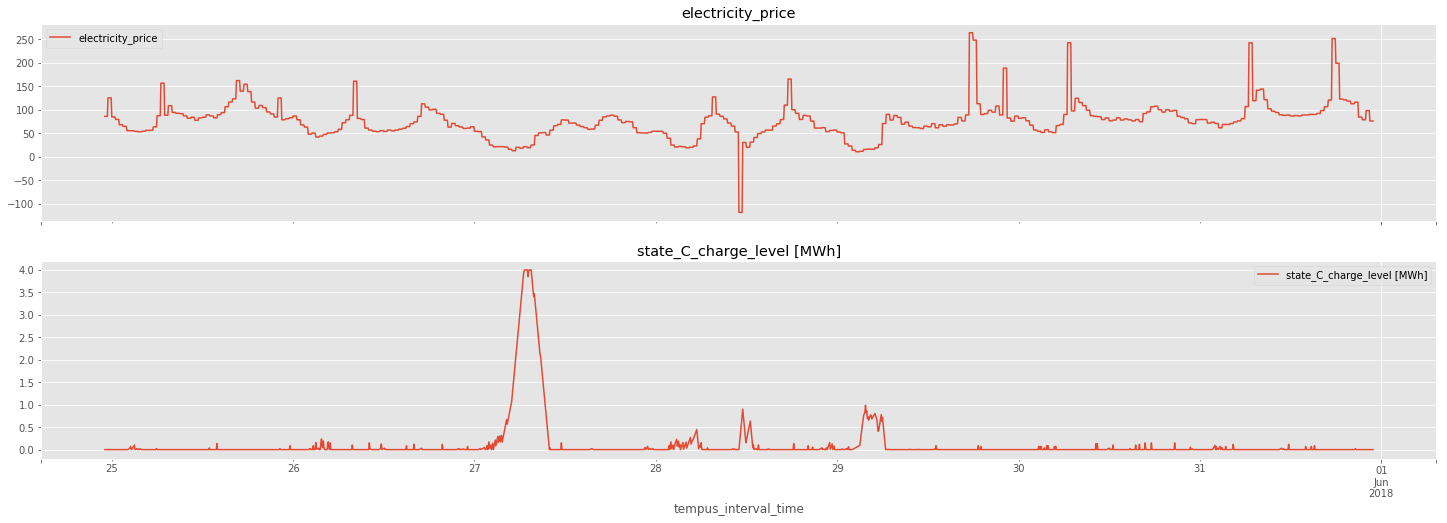

In [6]:
%matplotlib inline

#  plot the last episode
f = energy_py.experiments.plot_battery_episode(ep_hist)

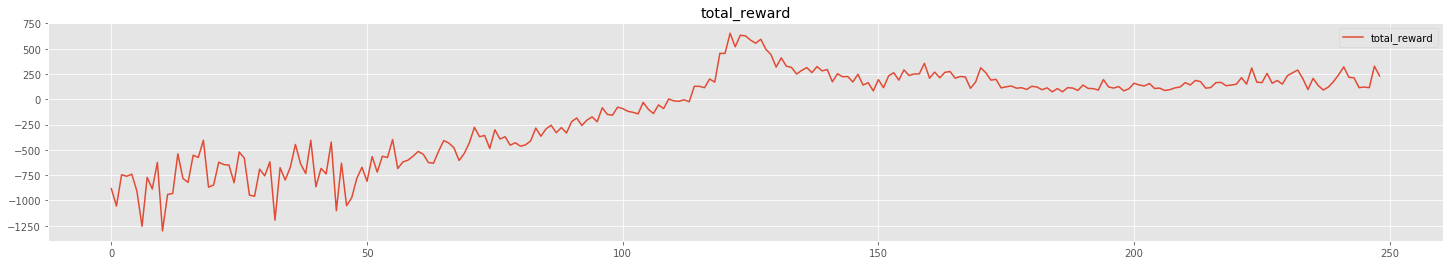

In [7]:
#  plot learning progress
f = energy_py.experiments.plot_time_series(
    pd.DataFrame(
        np.array(np.array(runner.episode_rewards).reshape(-1, 1)),
        columns=['total_reward']
    ),
    'total_reward'
)